# Week 5 assignemnt

The purpose of this assignment is to apply the art style of Monet to new photos. 

We are provided with original Monet paintings, around 300 of them. We are also provided with 7038 photos that we have to convert to a style that resemble Monet style painting. 

FOr this notebook, for full disclosure I will be using the architecture suggested by this notebook:

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

That being said. I will be making some tweaks to it and see what works well and what does not. So in the end we can give each model a look at the end. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)


2024-08-05 18:10:23.734646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 18:10:23.734758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 18:10:23.849966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0


# Data loading and inspecting

I will be using the tfrec files given by the assignemnt for this project. FOr this part I am alrgely borrowing the code from the tutorial notebook. But i had to make a few modifications to the code for it to work on my computer. 

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


The images in this dataset are already RGB. so we have 3 channels. 

Let's load the datasets then. 

In [3]:
IMAGE_SIZE = [256, 256]
NO_CHANNELS = 3

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, NO_CHANNELS])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# EDA: Visualize an example of picture and painting

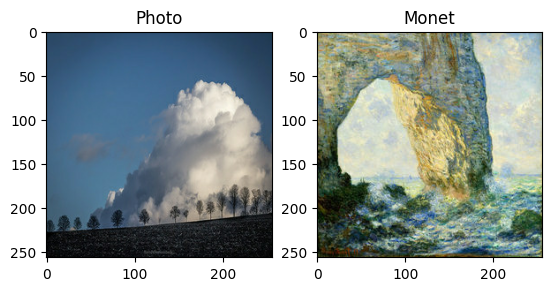

In [4]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [5]:
OUTPUT_CHANNELS = 3

def downsample_batch_norm_ReLU(filters, size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential([
        layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False)
    ])

    if apply_batch_norm:
        result.add(layers.BatchNormalization())

    result.add(layers.ReLU())

    return result

def upsample_batch_norm_ReLU(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential([layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False), 
                              layers.BatchNormalization()])

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def downsample_batch_norm_PReLU(filters, size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential([
        layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False)
    ])

    if apply_batch_norm:
        result.add(layers.BatchNormalization())

    result.add(layers.PReLU(alpha_initializer='Zeros'))

    return result

def upsample_batch_norm_PReLU(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential([layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False), 
                              layers.BatchNormalization()])

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.PReLU(alpha_initializer='Zeros'))

    return result

# Fitting final model and submission

In [6]:
def Generator_batch_norm_PReLU_filter_size_6():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample_batch_norm_PReLU(64, 6), # (bs, 128, 128, 64)
        downsample_batch_norm_PReLU(128, 6), # (bs, 64, 64, 128)
        downsample_batch_norm_PReLU(256, 6), # (bs, 32, 32, 256)
        downsample_batch_norm_PReLU(512, 6), # (bs, 16, 16, 512)
        downsample_batch_norm_PReLU(512, 6), # (bs, 8, 8, 512)
        downsample_batch_norm_PReLU(512, 6), # (bs, 4, 4, 512)
        downsample_batch_norm_PReLU(512, 6), # (bs, 2, 2, 512)
        downsample_batch_norm_PReLU(512, 6), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample_batch_norm_PReLU(512, 6, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample_batch_norm_PReLU(512, 6, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample_batch_norm_PReLU(512, 6, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample_batch_norm_PReLU(512, 6), # (bs, 16, 16, 1024)
        upsample_batch_norm_PReLU(256, 6), # (bs, 32, 32, 512)
        upsample_batch_norm_PReLU(128, 6), # (bs, 64, 64, 256)
        upsample_batch_norm_PReLU(64, 6), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator_batch_norm_PReLU_filter_size_6():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample_batch_norm_PReLU(64, 3, False)(x) # (bs, 128, 128, 64)
    down2 = downsample_batch_norm_PReLU(128, 3)(down1) # (bs, 64, 64, 128)
    down3 = downsample_batch_norm_PReLU(256, 3)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.PReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

with strategy.scope():
    monet_generator_batch_norm_PReLU_filter_size_6 = Generator_batch_norm_PReLU_filter_size_6()
    photo_generator_batch_norm_PReLU_filter_size_6 = Generator_batch_norm_PReLU_filter_size_6()
    
    monet_discriminator_batch_norm_PReLU_filter_size_6 = Discriminator_batch_norm_PReLU_filter_size_6()
    photo_discriminator_batch_norm_PReLU_filter_size_6 = Discriminator_batch_norm_PReLU_filter_size_6()

class CycleGan_batch_norm_PReLU_filter_size_6(keras.Model):
    def __init__(
        self,
        monet_generator_batch_norm_PReLU_filter_size_6,
        photo_generator_batch_norm_PReLU_filter_size_6,
        monet_discriminator_batch_norm_PReLU_filter_size_6,
        photo_discriminator_batch_norm_PReLU_filter_size_6,
        lambda_cycle=10,
    ):
        super(CycleGan_batch_norm_PReLU_filter_size_6, self).__init__()
        self.m_gen = monet_generator_batch_norm_PReLU_filter_size_6
        self.p_gen = photo_generator_batch_norm_PReLU_filter_size_6
        self.m_disc = monet_discriminator_batch_norm_PReLU_filter_size_6
        self.p_disc = photo_discriminator_batch_norm_PReLU_filter_size_6
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan_batch_norm_PReLU_filter_size_6, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

with strategy.scope():
    cycle_gan_model_batch_norm_PReLU_filter_size_6 = CycleGan_batch_norm_PReLU_filter_size_6(
        monet_generator_batch_norm_PReLU_filter_size_6, photo_generator_batch_norm_PReLU_filter_size_6, 
        monet_discriminator_batch_norm_PReLU_filter_size_6, photo_discriminator_batch_norm_PReLU_filter_size_6
    )

    cycle_gan_model_batch_norm_PReLU_filter_size_6.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model_batch_norm_PReLU_filter_size_6_history = cycle_gan_model_batch_norm_PReLU_filter_size_6.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20


I0000 00:00:1722881591.125187     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 321ms/step - monet_disc_loss: 0.6800 - monet_gen_loss: 7.5110 - photo_disc_loss: 0.6558 - photo_gen_loss: 7.7212
Epoch 2/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 103s 325ms/step - monet_disc_loss: 0.6425 - monet_gen_loss: 6.9436 - photo_disc_loss: 0.6228 - photo_gen_loss: 7.1453
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 320ms/step - monet_disc_loss: 0.6446 - monet_gen_loss: 6.5317 - photo_disc_loss: 0.6269 - photo_gen_loss: 6.7143
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 320ms/step - monet_disc_loss: 0.6425 - monet_gen_loss: 6.2287 - photo_disc_loss: 0.6262 - photo_gen_loss: 6.4451
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 316ms/step - monet_disc_loss: 0.6355 - monet_gen_loss: 6.0535 - photo_disc_loss: 0.6269 - photo_gen_loss: 6.2267
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 322ms/step - monet_disc_loss: 0.6405 - monet_gen_loss: 5.9318 - photo_disc_loss: 0.6075 - photo_gen_loss: 6.1475
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 321ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 5.8651 - photo_disc_loss: 0.6200 - photo_gen_loss: 6.0434
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 317ms/step - monet

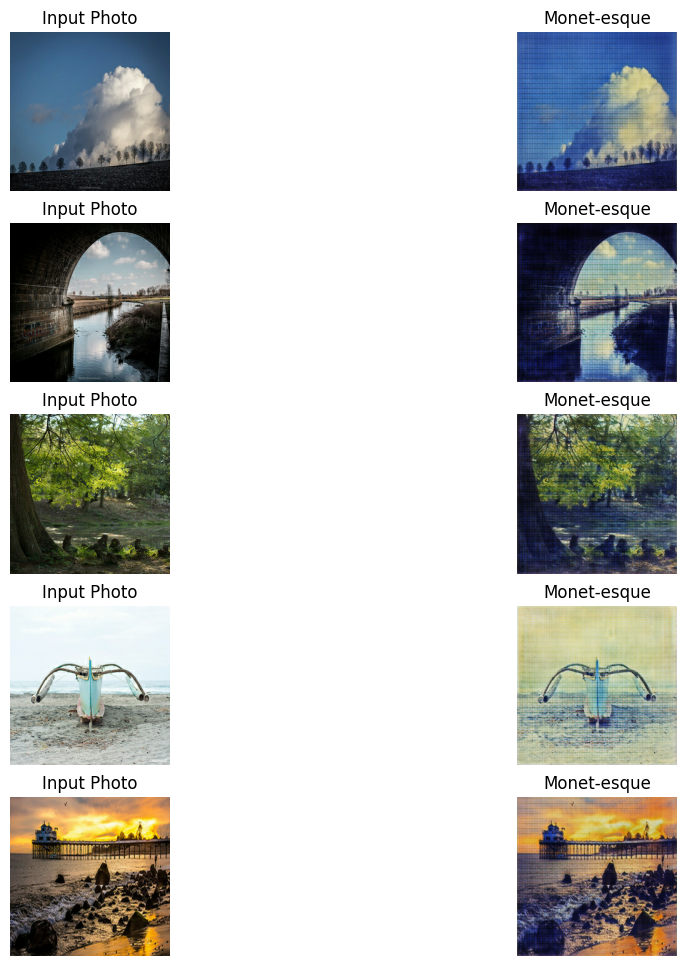

In [7]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator_batch_norm_PReLU_filter_size_6(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

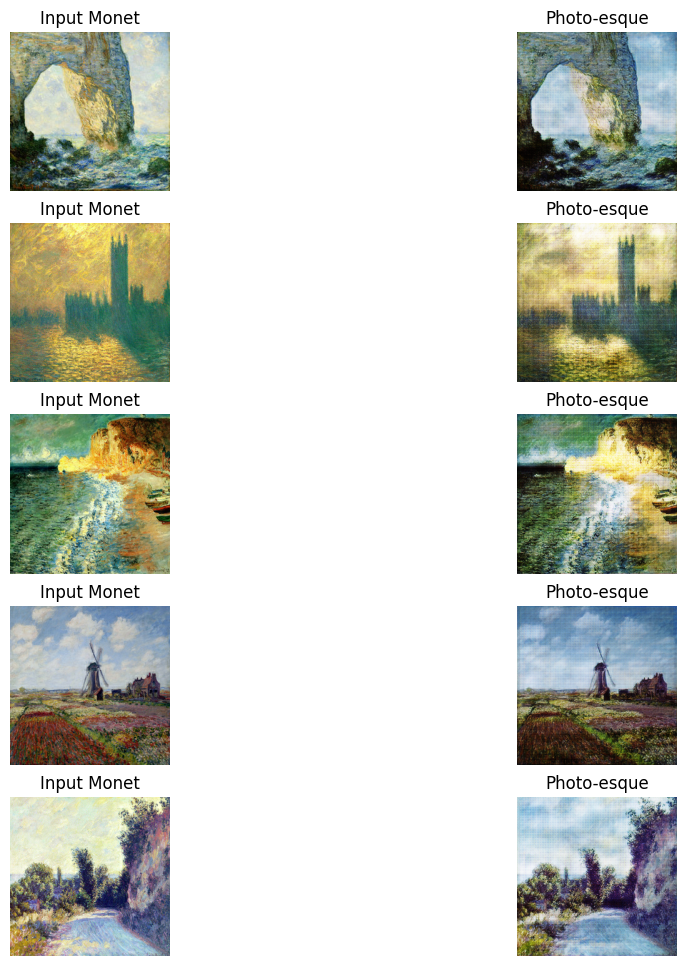

In [8]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(monet_ds.take(5)):
    prediction = photo_generator_batch_norm_PReLU_filter_size_6(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Monet")
    ax[i, 1].set_title("Photo-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [9]:
import PIL
! mkdir ../images

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
i = 1
for img in photo_ds:
    prediction = monet_generator_batch_norm_PReLU_filter_size_6(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [12]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'